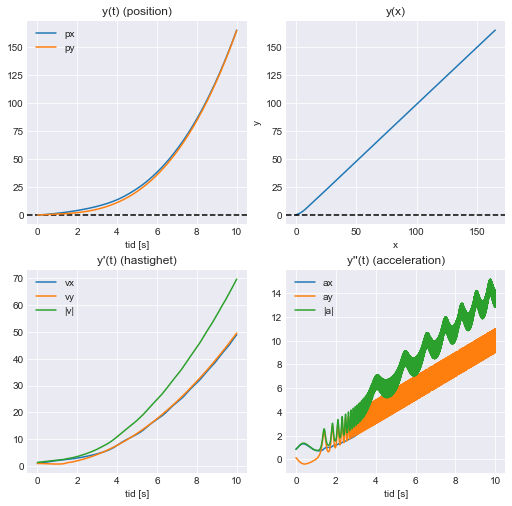

In [19]:
from euler_cromer import simulate
import numpy as np

def f(p, v, t):
    x, y = p; vx, vy = v
    return np.sin(np.array([2*vx-vy, 3*vy*vx]))+t

y0, v0 = [0, 0], [1, 1]
_ = simulate(f, [y0, v0], to_time=10, dt=0.001)